## Brute Force Approach

In [6]:
import os
os.chdir("..")

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product

from utils.Thesis_models import *
from utils import Thesis_viz as viz
from utils import synthetic_data_generation as sd

In [9]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def brute_force_combinations(input_set):
    
    def partition_set(set, index, ans):
        
        """
        Function to generate all partitions
        Source: https://www.geeksforgeeks.org/generate-all-partition-of-a-set/
        """
        partitions = []

        if index == len(set):
            partitions.append([subset.copy() for subset in ans])
            return partitions

        for i in range(len(ans)):
            ans[i].append(set[index])
            partitions.extend(partition_set(set, index + 1, ans))
            ans[i].pop()

        ans.append([set[index]])
        partitions.extend(partition_set(set, index + 1, ans))
        ans.pop()

        return partitions


    def all_partitions(set):
        ans = []
        return partition_set(set, 0, ans)

    partitions = all_partitions(input_set)
    
    combinations_to_compute = []
    for k in range(2,len(input_set)):
        [combinations_to_compute.append(sorted(i)) for i in partitions if len(i) == k]
        
    return combinations_to_compute

def get_number_of_possbile_combinations(number_of_groups):

    """
    Function to get total possible number of partitions
    Source: https://www.geeksforgeeks.org/generate-all-partition-of-a-set/
    """
    
    s = [[0 for _ in range(number_of_groups+1)] for _ in range(number_of_groups+1)]
    total_combinations = 0
    for i in range(number_of_groups+1):
        for j in range(number_of_groups+1):
            if j > i:
                continue
            elif(i==j):
                s[i][j] = 1
            elif(i==0 or j==0):
                s[i][j]=0
            else:
                s[i][j] = j*s[i-1][j] + s[i-1][j-1]
    for i in range(2,number_of_groups):
        total_combinations+=s[number_of_groups][i]
        
    return total_combinations

### Synthetic data parameters

In [15]:
seed = 50
mode = 'both'
effective_groups = 3
visible_groups = 7
number_of_contineous_features = 5

# random_effects_distribution = 'normal'; re_intercept = (0,5) ; re_slope = (0,5)
random_effects_distribution = 'linspace'; re_intercept = (-10,10) ; re_slope = (-10,10)

# error_type = 'on_group' ; re_error = (0,3)
error_type = 'on_target' ; re_error = (0,3)

shuffle_groups = True

### Synthetic data generation

In [16]:
df,_ = sd.create_data(
    n = 1000,
    n_effective_groups = effective_groups,
    n_visible_groups = visible_groups,
    n_contineous_features = 5,
    mode = mode,
    fixed_slope = (0, 1),
    fixed_intercept = 0,
    fixed_error=(0, 1),
    random_effects_distribution = random_effects_distribution,
    re_intercept = (-10, 10),
    re_slope = (-10, 10),
    error_type = error_type,
    re_error = (0, 3),
    random_seed = seed,
    shuffle_groups = shuffle_groups,
    show_random_effects = False
)
df

,f0,f1,f2,f3,f4,gE,gV,y
0,-0.010797,-0.543834,-0.489052,-0.207340,-0.245370,1,1,-6.673096
1,0.993148,-0.183606,0.543788,0.521073,-0.379981,1,1,-25.970612
2,-0.306918,-0.296470,-0.709066,0.945329,0.818357,1,1,-10.872763
3,0.119914,-0.372819,0.776400,0.349146,-0.217825,1,1,-22.960532
4,0.014368,0.048207,0.856002,0.142746,0.336675,1,1,-16.004217
...,...,...,...,...,...,...,...,...
995,-0.033881,0.289258,-0.238024,-0.035100,-0.829667,2,5,-5.274367
996,-0.738472,0.534579,0.588378,0.741214,-0.074996,2,5,24.974086
997,-0.348035,0.139808,-0.035477,0.023636,0.497246,2,5,10.379350
998,-0.073908,-0.417275,0.667721,-0.814868,-0.946318,2,5,-4.199309


In [17]:
input_set = list(df.gV.unique())
print("Possible Combinations: ", get_number_of_possbile_combinations(len(input_set)))

Possible Combinations:  875


In [18]:
# [MixedLM, LMMNN, LinearOHE, MERForest, ARMED]
Model = MERForest

In [19]:
mse_with_Effective_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gV'})[0]
mse_with_Visible_groups   = run_model(Model, {'df': df,'mode':mode,'to_drop':'gE'})[0]
print("MSE_Effective_groups: ", mse_with_Effective_groups)
print("MSE_Visible_groups: ", mse_with_Visible_groups)

MSE_Effective_groups:  19.281853581372264
MSE_Visible_groups:  27.51352515297248


In [20]:
start = time.time()

input_set = list(df.gV.unique())
combi = brute_force_combinations(input_set)
results = pd.DataFrame([])

for itr, i in enumerate(combi):
    
    my_tuple = i
    zone_indices = {index: list(inner_tuple) for index, inner_tuple in enumerate(my_tuple)}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    data = df.copy()
    data.drop(['gE', 'gV'], axis=1, inplace=True)
    data['gE_new'] = df['gV'].map(mapping_dict)
        
    results.at[itr, 'combi_nr'] = itr
    try:
        results.at[itr, 'mse'] = run_model(Model, {'df': data, 'mode': mode})[0]
    except np.linalg.LinAlgError:
        print(f"Singular Matrix error with MixedLM Model")
        results.at[itr, 'mse'] = np.nan
    
    print(f"Itr No: {itr}",combi[itr], results.at[itr, 'mse'], "\n")
    
end = time.time()

Itr No: 0 [[1, 6, 3, 0, 2, 4], [5]] 135.79533287419764 

Itr No: 1 [[1, 6, 3, 0, 2, 5], [4]] 110.45393537421934 

Itr No: 2 [[1, 6, 3, 0, 2], [4, 5]] 65.59440218883347 

Itr No: 3 [[1, 6, 3, 0, 4, 5], [2]] 166.42664277963004 

Itr No: 4 [[1, 6, 3, 0, 4], [2, 5]] 150.46121326211534 

Itr No: 5 [[1, 6, 3, 0, 5], [2, 4]] 127.81396180012082 

Itr No: 6 [[1, 6, 3, 0], [2, 4, 5]] 77.84372988423753 

Itr No: 7 [[0], [1, 6, 3, 2, 4, 5]] 168.941378422045 

Itr No: 8 [[0, 5], [1, 6, 3, 2, 4]] 149.57813945163056 

Itr No: 9 [[0, 4], [1, 6, 3, 2, 5]] 125.40561096763025 

Itr No: 10 [[0, 4, 5], [1, 6, 3, 2]] 73.0528144284403 

Itr No: 11 [[0, 2], [1, 6, 3, 4, 5]] 168.85608954184917 

Itr No: 12 [[0, 2, 5], [1, 6, 3, 4]] 148.14062910431898 

Itr No: 13 [[0, 2, 4], [1, 6, 3, 5]] 125.91670974458707 

Itr No: 14 [[0, 2, 4, 5], [1, 6, 3]] 57.29740770109474 

Itr No: 15 [[1, 6, 0, 2, 4, 5], [3]] 124.18951096080056 

Itr No: 16 [[1, 6, 0, 2, 4], [3, 5]] 170.23774834172067 

Itr No: 17 [[1, 6, 0, 2, 5], [3

Itr No: 410 [[0, 2], [1, 6], [3, 5], [4]] 91.01551389488029 

Itr No: 411 [[0, 2, 5], [1, 6], [3], [4]] 35.3084384204569 

Itr No: 412 [[0, 2], [1, 6], [3], [4, 5]] 16.55528118408523 

Itr No: 413 [[0], [1, 6, 4, 5], [2], [3]] 116.54411655168639 

Itr No: 414 [[0], [1, 6, 4], [2], [3, 5]] 165.0379239500435 

Itr No: 415 [[0, 5], [1, 6, 4], [2], [3]] 115.18391305174022 

Itr No: 416 [[0], [1, 6, 4], [2, 5], [3]] 115.7809279118168 

Itr No: 417 [[0], [1, 6, 5], [2], [3, 4]] 165.15117865431182 

Itr No: 418 [[0], [1, 6], [2], [3, 4, 5]] 131.88050280559273 

Itr No: 419 [[0, 5], [1, 6], [2], [3, 4]] 122.6329023012308 

Itr No: 420 [[0], [1, 6], [2, 5], [3, 4]] 132.3993213204599 

Itr No: 421 [[0, 4], [1, 6, 5], [2], [3]] 98.32566553450323 

Itr No: 422 [[0, 4], [1, 6], [2], [3, 5]] 117.32360769917007 

Itr No: 423 [[0, 4, 5], [1, 6], [2], [3]] 45.790356689524465 

Itr No: 424 [[0, 4], [1, 6], [2, 5], [3]] 56.08218652114524 

Itr No: 425 [[0], [1, 6, 5], [2, 4], [3]] 100.40381597443887 

It

Itr No: 542 [[1, 0, 2, 5], [3], [4], [6]] 65.89580545918233 

Itr No: 543 [[1, 0, 2], [3], [4], [6, 5]] 82.32347789215166 

Itr No: 544 [[1, 0, 2], [3, 5], [4], [6]] 112.1588063645909 

Itr No: 545 [[1, 0, 2], [3], [4, 5], [6]] 39.18927235886988 

Itr No: 546 [[1, 0, 4], [3], [5], [6, 2]] 112.84374992132658 

Itr No: 547 [[1, 0], [3], [5], [6, 2, 4]] 100.35086764166701 

Itr No: 548 [[1, 0], [3, 4], [5], [6, 2]] 152.19750520023086 

Itr No: 549 [[1, 0, 5], [3], [4], [6, 2]] 94.99035309685284 

Itr No: 550 [[1, 0], [3], [4], [6, 2, 5]] 85.08458188128559 

Itr No: 551 [[1, 0], [3, 5], [4], [6, 2]] 134.92666927129196 

Itr No: 552 [[1, 0], [3], [4, 5], [6, 2]] 57.9016803866471 

Itr No: 553 [[1, 0, 4], [3, 2], [5], [6]] 110.28244502266882 

Itr No: 554 [[1, 0], [3, 2], [5], [6, 4]] 114.34130674409482 

Itr No: 555 [[1, 0], [3, 2, 4], [5], [6]] 132.08395298202817 

Itr No: 556 [[1, 0, 5], [3, 2], [4], [6]] 95.23258463616486 

Itr No: 557 [[1, 0], [3, 2], [4], [6, 5]] 100.6745931967571 

It

Itr No: 674 [[0], [1, 5], [3, 4], [6, 2]] 162.42118294207256 

Itr No: 675 [[0], [1], [3, 4], [6, 2, 5]] 149.7816678177116 

Itr No: 676 [[0], [1], [3, 4, 5], [6, 2]] 144.68933268570908 

Itr No: 677 [[0, 5], [1], [3, 4], [6, 2]] 133.61416030867312 

Itr No: 678 [[0, 4], [1, 5], [3], [6, 2]] 100.5039760170511 

Itr No: 679 [[0, 4], [1], [3], [6, 2, 5]] 79.64887982565439 

Itr No: 680 [[0, 4], [1], [3, 5], [6, 2]] 118.17927482843616 

Itr No: 681 [[0, 4, 5], [1], [3], [6, 2]] 59.433543264049504 

Itr No: 682 [[0], [1, 4, 5], [3, 2], [6]] 102.04448330884036 

Itr No: 683 [[0], [1, 4], [3, 2], [6, 5]] 150.6697905181216 

Itr No: 684 [[0], [1, 4], [3, 2, 5], [6]] 150.2623888800149 

Itr No: 685 [[0, 5], [1, 4], [3, 2], [6]] 107.16144035438573 

Itr No: 686 [[0], [1, 5], [3, 2], [6, 4]] 150.23634011679445 

Itr No: 687 [[0], [1], [3, 2], [6, 4, 5]] 100.76352165449993 

Itr No: 688 [[0], [1], [3, 2, 5], [6, 4]] 147.34375785319844 

Itr No: 689 [[0, 5], [1], [3, 2], [6, 4]] 113.77308685276836

Itr No: 803 [[0], [1], [3], [5], [6, 2, 4]] 75.99358435993437 

Itr No: 804 [[0], [1], [3, 4], [5], [6, 2]] 138.8595893758335 

Itr No: 805 [[0, 4], [1], [3], [5], [6, 2]] 55.64799864296823 

Itr No: 806 [[0], [1, 5], [3], [4], [6, 2]] 94.89451611171964 

Itr No: 807 [[0], [1], [3], [4], [6, 2, 5]] 60.892077453916514 

Itr No: 808 [[0], [1], [3, 5], [4], [6, 2]] 119.1735181487041 

Itr No: 809 [[0, 5], [1], [3], [4], [6, 2]] 54.612783360492244 

Itr No: 810 [[0], [1], [3], [4, 5], [6, 2]] 33.477343842591566 

Itr No: 811 [[0], [1, 4], [3, 2], [5], [6]] 107.84491640266992 

Itr No: 812 [[0], [1], [3, 2], [5], [6, 4]] 98.52931525808185 

Itr No: 813 [[0], [1], [3, 2, 4], [5], [6]] 116.73274454416814 

Itr No: 814 [[0, 4], [1], [3, 2], [5], [6]] 63.70262831593827 

Itr No: 815 [[0], [1, 5], [3, 2], [4], [6]] 94.91531232258899 

Itr No: 816 [[0], [1], [3, 2], [4], [6, 5]] 85.75844557222136 

Itr No: 817 [[0], [1], [3, 2, 5], [4], [6]] 93.76893574777546 

Itr No: 818 [[0, 5], [1], [3, 2], [

In [21]:
print("Run Time: ", np.round((end-start),2)," s" )

Run Time:  1752.91  s


In [22]:
res = results.copy()
res['combinations'] = combi
res['n_subsets'] = [len(i) for i in combi]
res.head()

,combi_nr,mse,combinations,n_subsets
0,0.0,135.795333,"[[1, 6, 3, 0, 2, 4], [5]]",2
1,1.0,110.453935,"[[1, 6, 3, 0, 2, 5], [4]]",2
2,2.0,65.594402,"[[1, 6, 3, 0, 2], [4, 5]]",2
3,3.0,166.426643,"[[1, 6, 3, 0, 4, 5], [2]]",2
4,4.0,150.461213,"[[1, 6, 3, 0, 4], [2, 5]]",2


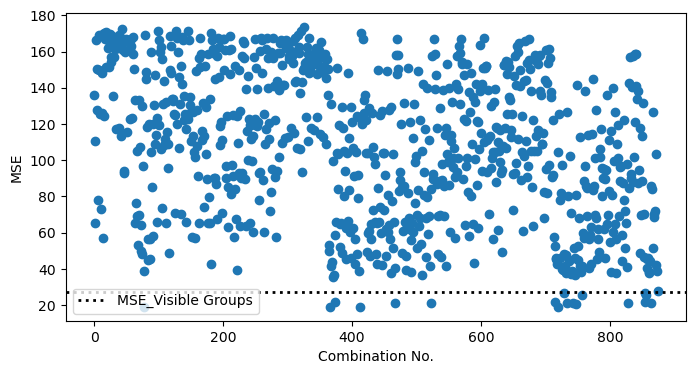

In [24]:
plt.figure(figsize = (8,4), dpi = 100)
plt.scatter(res.combi_nr, res.mse)
mse_gV = run_model(Model, {'df': df,'mode':mode,'to_drop':'gE'})[0]
plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'k', ls=':', linewidth = 2, label = 'MSE_Visible Groups')
plt.xlabel("Combination No.")
plt.ylabel("MSE")
plt.legend()

### Optimal clustering of groups of Synthetic data

In [28]:
zone_indices_actual = {zone : list(np.unique(df[df['gE'] == zone]['gV'])) for zone in np.unique(df.gE)}
for i in np.unique(df.gE):
    print(i," : ",zone_indices_actual[i])

0  :  [0, 2]
1  :  [1, 3, 6]
2  :  [4, 5]


In [29]:
res.sort_values(by='mse')

,combi_nr,mse,combinations,n_subsets
366,366.0,19.176586,"[[0, 2], [1, 6, 3], [4], [5]]",4
412,412.0,19.235213,"[[0, 2], [1, 6], [3], [4, 5]]",4
719,719.0,19.268488,"[[0, 2], [1, 6], [3], [4], [5]]",5
78,78.0,19.276381,"[[0, 2], [1, 6, 3], [4, 5]]",3
747,747.0,20.783970,"[[0, 2], [1], [4], [5], [6, 3]]",5
...,...,...,...,...
127,127.0,171.135949,"[[0], [1, 6, 2, 4], [3, 5]]",3
145,145.0,171.323783,"[[0, 2], [1, 6, 4], [3, 5]]",3
99,99.0,171.397150,"[[1, 6, 0, 4], [2], [3, 5]]",3
43,43.0,172.663588,"[[1, 3, 4, 5], [6, 0, 2]]",2
